In [25]:
pip install openmeteo-requests

In [3]:
pip install requests-cache retry-requests numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00


In [26]:
import openmeteo_requests

In [27]:
import pandas as pd

In [28]:
import requests_cache

In [29]:
from retry_requests import retry

In [30]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [31]:
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 55.67,
	"longitude": 12.56,
  "hourly": ["temperature_2m", "precipitation_probability", "cloud_cover", "wind_speed_10m"],
}
responses = openmeteo.weather_api(url, params=params)

In [32]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 55.669254302978516°N 12.555206298828125°E
Elevation 11.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [33]:
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation_probability = hourly.Variables(1).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()

In [35]:
hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation_prob"] = hourly_precipitation_probability
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

                         date  temperature_2m  precipitation_prob  \
0   2024-06-07 00:00:00+00:00       10.574000                 0.0   
1   2024-06-07 01:00:00+00:00       10.474000                 0.0   
2   2024-06-07 02:00:00+00:00       10.324000                 0.0   
3   2024-06-07 03:00:00+00:00       10.424000                 0.0   
4   2024-06-07 04:00:00+00:00       11.074000                 2.0   
..                        ...             ...                 ...   
163 2024-06-13 19:00:00+00:00       14.111000                30.0   
164 2024-06-13 20:00:00+00:00       13.061001                24.0   
165 2024-06-13 21:00:00+00:00       12.161000                19.0   
166 2024-06-13 22:00:00+00:00       11.511001                19.0   
167 2024-06-13 23:00:00+00:00       10.961000                19.0   

     cloud_cover  wind_speed_10m  
0            7.0        9.360000  
1           59.0        9.000000  
2           88.0        8.280000  
3           78.0        8.28000

Text(0, 0.5, '[%]')

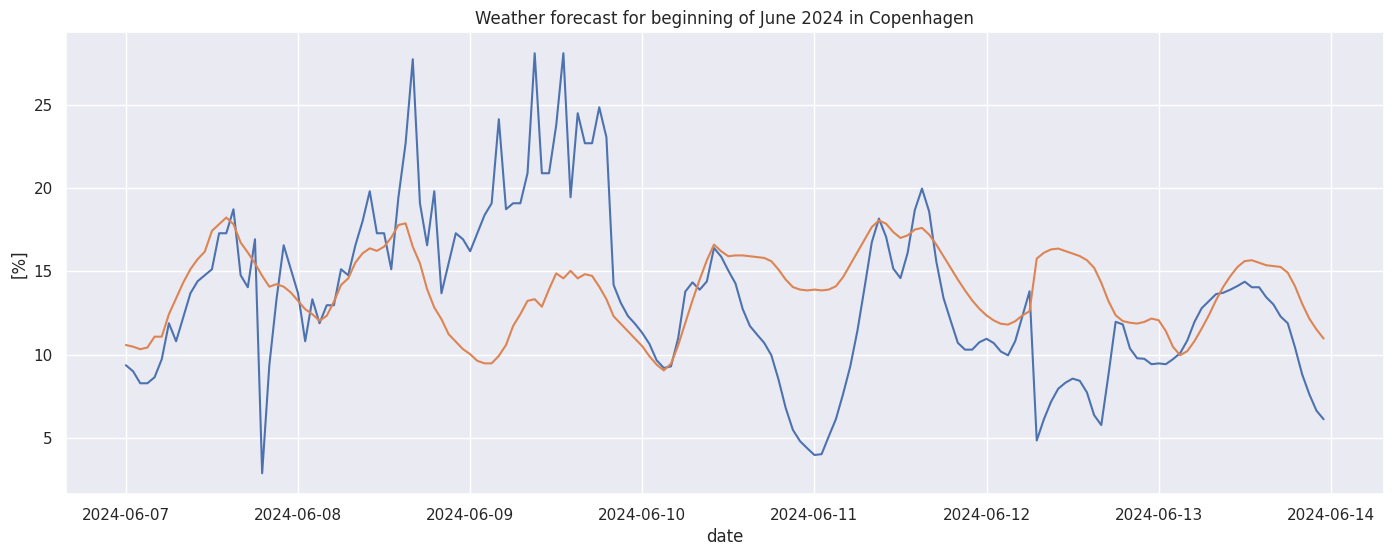

In [100]:
# Set the width and height of the figure
plt.figure(figsize=(17,6))
plt.title("Weather forecast for beginning of June 2024 in Copenhagen")

#sns.heatmap(data=hourly_dataframe, x=hourly_dataframe.date, y=hourly_dataframe.wind_speed_10m)
sns.lineplot(x=hourly_dataframe.date, y=hourly_dataframe.wind_speed_10m )
sns.lineplot(x=hourly_dataframe.date, y=hourly_dataframe.temperature_2m
             #y=hourly_dataframe.wind_speed_10m
            #annot=True
            #hue="cloud_cover"
            )
#sns.lineplot(data=hourly_dataframe.date)
#sns.lineplot(data=fmri, x="timepoint", y="signal", hue="event")
plt.xlabel("date")
plt.ylabel("[%]")
#sns.lineplot(x="timepoint", y="date",
#hue="region", #style="[%]]",

#hourly_dataframe